**Important**: to run the notebook, launch jupyter notebook from the anaconda prompt after having activated the environment

**Environment for the project**: aggregated_SBP_adoption_dataset

**Requirements**: numpy pandas xlrd openpyxl

**NOTE:** Possible to select two input files depending on the split of pre-PCF adoption. See first cells.

## Content
* PCF project: retrieve adoption over each municipality
* Merge of adoption previous and during PCF -> Yearly SBP adoption per municipality
* Get derivate datasets:
    * Cumulative adoption in each year
    * Yearly and cumulative for Portugal
    * Adoption in neighbours
* Datasets merging
* Values relative to permanent pasture area
    * Create and save dataset with % adoption in munic for ABM initialisation
    * Save datasets for ABM validation

Notebook to analyse the data regarding the aggregate SBP adoption before 2008 and the one during the Terraprima-Portuguese Carbon Fund project (PCF project).
Also, here is created a dataset containing the aggregate SBP adoption from 1996 to 2012.

In [1]:
import numpy as np
import pandas as pd

# Data ingestion and manipulation

In [2]:
path_to_PCF_data = "./From spatial granularity harmonization/PCF project data_Corrected counties.xlsx"

Version 1 split pre-PCF: all municipalities possible, proportionally to the pasture area

In [3]:
path_to_adoption_pre_PCF = "./From spatial granularity harmonization/SBP adoption previous to 2009 per municipality.xlsx"
out_file = "./Final SBP adoption datasets/SBP yearly adoption + adoption features.csv"
out_path_adoption_percentage = "./Final SBP adoption datasets/SBP % yearly adoption + % adoption features.csv"

Version 2 split pre-PCF: only municipalities PCF (if any), proportionally to the pasture area

## PCF project

In [4]:
# If needed, can be included the Farm_ID column to identify if the same farmer adopted multiple parcels

PCF_data = pd.read_excel(path_to_PCF_data, index_col=0)
PCF_data.head()

,Farmer_ID,Year that the pasture was installed,County,Area_Total_SIG_PPI_2009_ha,Area_Total_SIG_PPI_2010_ha,Area_Total_SIG_PPII_2011_ha,Area_Total_SIG_PPII_2012_ha
Parcel_ID,,,,,,,
55,1,2009,Idanha-a-Nova,9.28,0.00,0.00,0.00
410,2,2010,Évora,0.00,3.21,0.00,0.00
681,2,2011,Évora,0.00,0.00,6.83,0.00
1068,3,2012,Reguengos de Monsaraz,0.00,0.00,0.00,38.17
584,4,2010,Avis,0.00,9.57,0.00,0.00


In [5]:
PCF_data = PCF_data.drop('Farmer_ID', axis=1)

In [6]:
PCF_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113 entries, 55 to 1048
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year that the pasture was installed  1113 non-null   int64  
 1   County                               1113 non-null   object 
 2   Area_Total_SIG_PPI_2009_ha           1113 non-null   float64
 3   Area_Total_SIG_PPI_2010_ha           1113 non-null   float64
 4   Area_Total_SIG_PPII_2011_ha          1113 non-null   float64
 5   Area_Total_SIG_PPII_2012_ha          1113 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 60.9+ KB


### Check years have only values from 2009 to 2014

In [7]:
PCF_data['Year that the pasture was installed'].value_counts()

2010    310
2012    289
2009    279
2011    235
Name: Year that the pasture was installed, dtype: int64

### Check if any parcel adopted in multiple years, i.e. if any has two non zero values in the total area adopted each year

In [8]:
cols_with_area = ['Area_Total_SIG_PPI_2009_ha', 
                 'Area_Total_SIG_PPI_2010_ha', 
                 'Area_Total_SIG_PPII_2011_ha', 
                 'Area_Total_SIG_PPII_2012_ha']

number_of_year_adopted = len(cols_with_area) - (PCF_data[cols_with_area] == 0).sum(axis=1)

In [9]:
adopted_1_year = number_of_year_adopted == 1
all(adopted_1_year)

False

In [10]:
# Number of parcels which have correctly one adoption
sum(adopted_1_year)

1100

In [11]:
adopted_0_years = number_of_year_adopted == 0
sum(adopted_0_years)

13

Therefore, there are 1100 for which we have the area adopted and 13 for which we have not data on the area adopted that we can exclude.

In [12]:
parcels_without_adoption = PCF_data[adopted_0_years]
parcels_without_adoption.head()

,Year that the pasture was installed,County,Area_Total_SIG_PPI_2009_ha,Area_Total_SIG_PPI_2010_ha,Area_Total_SIG_PPII_2011_ha,Area_Total_SIG_PPII_2012_ha
Parcel_ID,,,,,,
414,2010,Évora,0.0,0.0,0.0,0.0
359,2010,Alcácer do Sal,0.0,0.0,0.0,0.0
106,2009,Arraiolos,0.0,0.0,0.0,0.0
249,2009,Alter do Chão,0.0,0.0,0.0,0.0
1061,2012,Vila Viçosa,0.0,0.0,0.0,0.0


In [13]:
PCF_data = PCF_data.drop(parcels_without_adoption.index)

In [14]:
len(PCF_data)

1100

Since each parcel adopted in one year and the DataFrame has a column for the year of adoption, we can substitute the last columns with the area of adoption with just one columns having the area adopted in any year.

In [15]:
PCF_data[cols_with_area].max(axis=1)
PCF_data['Area'] = PCF_data[cols_with_area].max(axis=1)

In [16]:
PCF_data = PCF_data.drop(cols_with_area, axis=1)

In [17]:
PCF_data.head()

,Year that the pasture was installed,County,Area
Parcel_ID,,,
55,2009,Idanha-a-Nova,9.28
410,2010,Évora,3.21
681,2011,Évora,6.83
1068,2012,Reguengos de Monsaraz,38.17
584,2010,Avis,9.57


### Get municipality adoption per municipality, per year

In [18]:
munic_adoption_MI = PCF_data.groupby(['County', 'Year that the pasture was installed']).sum()
munic_adoption_MI.head()

Area
County    Year that the pasture was installed        
Abrantes  2009                                  67.24
          2010                                 241.73
          2011                                  52.38
          2012                                 156.63
Alandroal 2009                                 205.70

Rearrange to have the years as a columns and bring in the same format as the SBP adoption previous to the PCF project

In [19]:
munic_adoption_PCF = munic_adoption_MI.unstack(fill_value=0)
munic_adoption_PCF.head()

Area                         
Year that the pasture was installed     2009     2010    2011    2012
County                                                               
Abrantes                               67.24   241.73   52.38  156.63
Alandroal                             205.70   557.06  167.75  934.91
Alcochete                               0.00   347.12  238.65  348.91
Alcácer do Sal                       1084.30  1112.69  720.92  644.67
Alenquer                                0.00     0.00   14.66    0.00

In [20]:
munic_adoption_PCF.columns.names = (None, None)
munic_adoption_PCF.head()

Area                         
                   2009     2010    2011    2012
County                                          
Abrantes          67.24   241.73   52.38  156.63
Alandroal        205.70   557.06  167.75  934.91
Alcochete          0.00   347.12  238.65  348.91
Alcácer do Sal  1084.30  1112.69  720.92  644.67
Alenquer           0.00     0.00   14.66    0.00

In [21]:
munic_adoption_PCF.index.name = 'Municipality'

In [22]:
munic_adoption_PCF.columns = munic_adoption_PCF.columns.droplevel()
munic_adoption_PCF.head()

,2009,2010,2011,2012
Municipality,,,,
Abrantes,67.24,241.73,52.38,156.63
Alandroal,205.70,557.06,167.75,934.91
Alcochete,0.00,347.12,238.65,348.91
Alcácer do Sal,1084.30,1112.69,720.92,644.67
Alenquer,0.00,0.00,14.66,0.00


In [23]:
len(munic_adoption_PCF)

73

#### Retrieve list of municipalities which adopted during the PCF project

In [24]:
munic_adoption_PCF_list = munic_adoption_PCF.index.tolist()

In [27]:
import csv

with open("list_of_munic_that_adopted_during_PCF.csv", "w+") as file:
    wr = csv.writer(file)
    wr.writerow(munic_adoption_PCF_list)

## SBP adoption previous to the PCF project

In [65]:
munic_adoption_pre_PCF = pd.read_excel(path_to_adoption_pre_PCF, index_col=0)
munic_adoption_pre_PCF

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
Municipality,,,,,,,,,,,,,
Alcácer do Sal,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Grândola,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Odemira,34.000000,110.000000,272.000000,237.000000,554.000000,726.000000,846.000000,1672.000000,877.000000,455.000000,462.000000,679.000000,879.000000
Santiago do Cacém,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sines,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Murça,0.009810,0.024525,0.156961,0.171676,0.147151,0.201106,0.372782,0.436548,0.539554,0.338447,0.412023,0.588604,0.475788
Valpaços,0.062365,0.155913,0.997846,1.091394,0.935481,1.278490,2.369884,2.775259,3.430096,2.151606,2.619346,3.741923,3.024721
Vila Pouca de Aguiar,0.113100,0.282749,1.809595,1.979244,1.696495,2.318543,4.297787,5.032935,6.220482,3.901939,4.750186,6.785980,5.485334


In [66]:
len(munic_adoption_pre_PCF)

262

# Municipalities comparison 

In [67]:
munic_PCF = munic_adoption_PCF.index.tolist()
munic_pre_PCF = munic_adoption_pre_PCF.index.tolist()

In [68]:
munic_in_PCF_not_in_prePCF = [munic for munic in munic_PCF if munic not in munic_pre_PCF]
munic_in_PCF_not_in_prePCF

[]

In [69]:
munic_in_prePCF_not_in_PCF = [munic for munic in munic_pre_PCF if munic not in munic_PCF]
len(munic_in_prePCF_not_in_PCF)

189

## Dataset merging

In [70]:
munic_adoption = pd.concat([munic_adoption_pre_PCF, munic_adoption_PCF], axis=1)

In [71]:
munic_adoption[munic_adoption.isna()] = 0

In [72]:
munic_adoption.index.name = 'Municipality'

Add a columns for 1995 with all 0s, since adoption values in 1995 serves to predict the adoption in 1996.

In [73]:
munic_adoption.insert(0, 1995, 0)

## Save dataset

In [74]:
file_munic_adoption = "./Final SBP adoption datasets/Yearly SBP adoption per municipality.xlsx"

In [75]:
munic_adoption.to_excel(file_munic_adoption)

# Get derivate datasets

## Cumulative SBP adoption per municipality

In [76]:
cumulative_total_munic_adoption = munic_adoption.cumsum(axis=1)
cumulative_total_munic_adoption

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Municipality,,,,,,,,,,,,,,,,,,
Alcácer do Sal,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1084.300000,2196.990000,2917.910000,3562.580000
Grândola,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78.140000,144.590000,162.890000,208.020000
Odemira,0.0,34.000000,144.000000,416.000000,653.000000,1207.000000,1933.000000,2779.000000,4451.000000,5328.000000,5783.000000,6245.000000,6924.000000,7803.000000,7806.450000,7984.030000,8065.530000,8227.980000
Santiago do Cacém,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.680000,155.820000,155.820000,216.240000
Sines,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Murça,0.0,0.009810,0.034335,0.191296,0.362972,0.510123,0.711230,1.084012,1.520560,2.060114,2.398561,2.810584,3.399187,3.874976,3.874976,3.874976,3.874976,3.874976
Valpaços,0.0,0.062365,0.218279,1.216125,2.307519,3.243000,4.521490,6.891375,9.666634,13.096730,15.248336,17.867682,21.609604,24.634325,24.634325,24.634325,24.634325,24.634325
Vila Pouca de Aguiar,0.0,0.113100,0.395849,2.205444,4.184688,5.881183,8.199726,12.497513,17.530448,23.750930,27.652869,32.403055,39.189035,44.674369,44.674369,44.674369,44.674369,44.674369


Save file

## Cumulative SBP adoption per municipality over the previous 10 years

In [77]:
munic_adoption.loc['Odemira'].loc[1997:2006].sum()

6211.0

In [78]:
cumulative_10_y_munic_adoption = munic_adoption.rolling(window=10, min_periods=1, axis=1).sum()
cumulative_10_y_munic_adoption

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Municipality,,,,,,,,,,,,,,,,,,
Alcácer do Sal,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1084.300000,2196.990000,2917.910000,3562.580000
Grândola,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78.140000,144.590000,162.890000,208.020000
Odemira,0.0,34.000000,144.000000,416.000000,653.000000,1207.000000,1933.000000,2779.000000,4451.000000,5328.000000,5783.000000,6211.000000,6780.000000,7387.000000,7153.450000,6777.030000,6132.530000,5448.980000
Santiago do Cacém,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.680000,155.820000,155.820000,216.240000
Sines,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Murça,0.0,0.009810,0.034335,0.191296,0.362972,0.510123,0.711230,1.084012,1.520560,2.060114,2.398561,2.800773,3.364852,3.683679,3.512003,3.364852,3.163746,2.790963
Valpaços,0.0,0.062365,0.218279,1.216125,2.307519,3.243000,4.521490,6.891375,9.666634,13.096730,15.248336,17.805316,21.391326,23.418201,22.326806,21.391326,20.112835,17.742951
Vila Pouca de Aguiar,0.0,0.113100,0.395849,2.205444,4.184688,5.881183,8.199726,12.497513,17.530448,23.750930,27.652869,32.289955,38.793186,42.468925,40.489681,38.793186,36.474643,32.176855


Save file

## Datasets for Portugal

Dataset reporting for Portugal both the yarly adoption and the cumulative adoption

In [79]:
portugal_adoption = pd.DataFrame(columns=cumulative_total_munic_adoption.columns)

In [80]:
portugal_adoption.loc['Yearly adoption'] = munic_adoption.sum()
portugal_adoption.loc['Cumulative adoption 10 years'] = cumulative_10_y_munic_adoption.sum()
portugal_adoption.loc['Total cumulative adoption'] = cumulative_total_munic_adoption.sum()

In [81]:
portugal_adoption

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Yearly adoption,0.0,1672.0,1947.5,3956.0,3918.5,3871.5,5300.0,7833.0,10779.0,12413.0,8066.0,7391.0,9944.0,5966.0,12585.72,15485.48,9571.6,14136.67
Cumulative adoption 10 years,0.0,1672.0,3619.5,7575.5,11494.0,15365.5,20665.5,28498.5,39277.5,51690.5,59756.5,65475.5,73472.0,75482.0,84149.22,95763.20,100034.8,106338.47
Total cumulative adoption,0.0,1672.0,3619.5,7575.5,11494.0,15365.5,20665.5,28498.5,39277.5,51690.5,59756.5,67147.5,77091.5,83057.5,95643.22,111128.70,120700.3,134836.97


Save file

<AxesSubplot:>

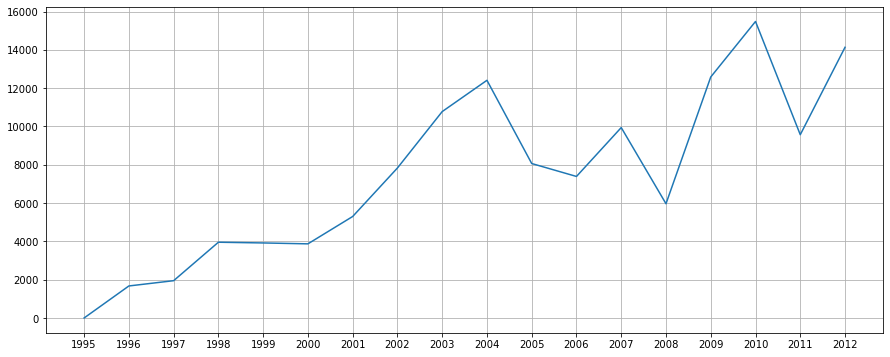

In [82]:
portugal_adoption.loc['Yearly adoption'].plot(figsize=(15,6), xticks=portugal_adoption.columns, grid=True)

## Adoption in neighbouring municipalities

In [83]:
file_with_neighbours = "../counties_shp/Neighbouring municipalities/municipalities_neighbours.csv"

In [84]:
munic_neighbours = pd.read_csv(file_with_neighbours, index_col='Municipality')
munic_neighbours.drop(['CCA_2', 'District'], axis=1, inplace=True)

Convert the columns having lists to the right type (read as lists by read_csv)

In [85]:
from ast import literal_eval
for col in munic_neighbours.columns:
    munic_neighbours[col] = munic_neighbours[col].apply(literal_eval)

Get average adoption for each list of neighbouring municipalities

In [86]:
def get_total_adoption_from_munic_year(munic_list, year):
    munic_adoption_values = [munic_adoption.loc[munic, year] for munic in munic_list]
    total = sum(munic_adoption_values)
    return total

In [87]:
def create_yearly_df_adoption_from_neighbours(column):
    """
    Create from a column of neighbouring municipalities a dataframe with the average adoption over them, 
    for all the years for which we have data, then calculates cumulative over 10 years and total cumulative
    """

    yearly_adoption = pd.DataFrame(index=munic_neighbours.index, columns=munic_adoption.columns)
    neighbours = munic_neighbours[column]
    for year in yearly_adoption.columns:
        yearly_adoption[year] = neighbours.apply(get_total_adoption_from_munic_year, args=(year,)).values
    
    cum_tot_adoption = yearly_adoption.cumsum(axis=1)
    
    cum_10_y_adoption = yearly_adoption.rolling(window=10, min_periods=1, axis=1).sum()
    
    return (yearly_adoption, cum_tot_adoption, cum_10_y_adoption)

In [88]:
munic_neighbours_adoption = {}
for neighbours_scope in munic_neighbours.columns:
    munic_neighbours_adoption[neighbours_scope] = create_yearly_df_adoption_from_neighbours(neighbours_scope)

# Datasets merging for data analysis

For data analysis purposes, I need a dataset having one row for each municipality for each year. The label is the adoption in that year. The features refer to the previous year.

In [89]:
def multiindex_from_dataframe_columns(df, col_name, previous_year=False):
    """
    Function to create a multiindex from a dataframe, with the columns of the dataframe becoming the second level of the 
    multiindex.
    """
    keys = df.index.tolist()
    years = [y for y in df.columns.tolist() if y !=1995]
    mi = pd.MultiIndex.from_product([keys, years])
    mi = mi.to_frame()
    mi.drop(mi.columns, axis=1, inplace=True)
    for key in keys:
        for year in years:
            if previous_year:
                mi.loc[(key, year), col_name] = df.loc[key, year-1]
            else:
                mi.loc[(key, year), col_name] = df.loc[key, year]
    return mi

In [90]:
labels = multiindex_from_dataframe_columns(munic_adoption, 'adoption_in_year')

## Add features

labels is the set of labels. Now let's add the features

### Adoption of the previous year in the municipality

In [91]:
adoption_previous_year_munic = multiindex_from_dataframe_columns(munic_adoption, 
                                                                'adoption_pr_y_munic',
                                                                previous_year=True)

### Total cumulative adoption previous year municipality

The cumnuative adoptions are including the year of the columns, therefore need to be added considering this (previous_year=True)

In [92]:
tot_cum_adoption_previous_year_munic = multiindex_from_dataframe_columns(cumulative_total_munic_adoption,
                                                                        'tot_cumul_adoption_pr_y_munic',
                                                                        previous_year=True)

### Cumulative adoption over 10 years previous year municipality

In [93]:
cum_adoption_10_y_previous_year_munic = multiindex_from_dataframe_columns(cumulative_10_y_munic_adoption,
                                                                    'cumul_adoption_10_y_pr_y_munic',
                                                                    previous_year=True)

In [104]:
# Check
cum_adoption_10_y_previous_year_munic.loc['Odemira'].loc[2007].values[0] == munic_adoption.loc['Odemira'].loc[1997:2006].sum()

True

### Neighbouring municipalities datasets

In [94]:
datasets_neighbours_mi = []
for neighbours_scope, datasets in munic_neighbours_adoption.items():
    prev_year_adoption = multiindex_from_dataframe_columns(datasets[0],
                                                           'adoption_pr_y_' + neighbours_scope,
                                                           previous_year = True)
    tot_cumul_adoption = multiindex_from_dataframe_columns(datasets[1],
                                                           'tot_cumul_adoption_pr_y_' + neighbours_scope,
                                                           previous_year = True)
    cum_adoption_10_y = multiindex_from_dataframe_columns(datasets[2],
                                                           'cumul_adoption_10_y_pr_y_' + neighbours_scope,
                                                           previous_year = True)   
    datasets_neighbours_mi.append(prev_year_adoption)
    datasets_neighbours_mi.append(tot_cumul_adoption)
    datasets_neighbours_mi.append(cum_adoption_10_y)

### Concatenate datasets with yearly values

In [95]:
datasets = [labels, adoption_previous_year_munic, tot_cum_adoption_previous_year_munic, cum_adoption_10_y_previous_year_munic] + datasets_neighbours_mi 

In [96]:
SBP_adoption_final = pd.concat(datasets, axis=1)

In [106]:
SBP_adoption_final.index.rename(['Municipality', 'Year'], inplace=True)

### Add Portugal yearly and cumulative adoption in the previous year

In [107]:
from itertools import cycle

def add_col_depending_on_year_not_on_munic(final_dataset, df_rows_to_append, cols_names):
    yearly_values = cycle(df_rows_to_append.transpose().to_numpy())
    final_dataset[cols_names] = [next(yearly_values) for i in range(len(final_dataset))]

In [108]:
cols_to_append = portugal_adoption.loc[:, 1995:2011]
cols_names = ['adoption_pr_y_port', 'tot_cumul_adoption_pr_y_port', 'cumul_adoption_10_y_pr_y_port']

add_col_depending_on_year_not_on_munic(SBP_adoption_final, cols_to_append, cols_names)

## Remove Porto, Lisboa and São João da Madeira (since no data in the census)

In [109]:
to_drop = ['Lisboa', 'Porto', 'São João da Madeira']
SBP_adoption_final.drop(to_drop, level='Municipality', inplace=True)

# Save final dataset

In [110]:
SBP_adoption_final.head(17)

adoption_in_year  adoption_pr_y_munic  \
Municipality Year                                          
Abrantes     1996             77.00                 0.00   
             1997             42.00                77.00   
             1998             12.00                42.00   
             1999             39.00                12.00   
             2000             37.00                39.00   
             2001             21.00                37.00   
             2002             79.00                21.00   
             2003              0.00                79.00   
             2004             20.00                 0.00   
             2005             18.00                20.00   
             2006              0.00                18.00   
             2007             48.00                 0.00   
             2008              8.00                48.00   
             2009             67.24                 8.00   
             2010            241.73                67.24   
             2011             52.38               241.73   
             2012            156.63                52.38   

                   tot_cumul_adoption_pr_y_munic  \
Municipality Year                                  
Abrantes     1996                           0.00   
             1997                          77.00   
             1998                         119.00   
             1999                         131.00   
             2000                         170.00   
             2001                         207.00   
             2002                         228.00   
             2003                         307.00   
             2004                         307.00   
             2005                         327.00   
             2006                         345.00   
             2007                         345.00   
             2008                         393.00   
             2009                         401.00   
             2010                         468.24   
             2011                         709.97   
             2012                         762.35   

                   cumul_adoption_10_y_pr_y_munic  \
Municipality Year                                   
Abrantes     1996                            0.00   
             1997                           77.00   
             1998                          119.00   
             1999                          131.00   
             2000                          170.00   
             2001                          207.00   
             2002                          228.00   
             2003                          307.00   
             2004                          307.00   
             2005                          327.00   
             2006                          345.00   
             2007                          268.00   
             2008                          274.00   
             2009                          270.00   
             2010                          298.24   
             2011                          502.97   
             2012                          534.35   

                   adoption_pr_y_neighbours_adj  \
Municipality Year                                 
Abrantes     1996                      0.000000   
             1997                    150.364852   
             1998                     98.052486   
             1999                    350.868176   
             2000                    348.353202   
             2001                    323.526295   
             2002                    745.400798   
             2003                    410.621551   
             2004                   1011.026565   
             2005                   1240.232926   
             2006                    810.149986   
             2007                    392.414860   
             2008                   1033.292486   
             2009                    126.613058   
             2010                    286.140000   
             2

In [111]:
SBP_adoption_final.to_csv(out_file)

In [149]:
SBP_adoption_final.loc[SBP_adoption_final.index.get_level_values(1) == 2012]['tot_cumul_adoption_pr_y_munic'].describe()

count      259.000000
mean       466.024324
std       1549.531654
min          0.000000
25%          2.210541
50%         21.741134
75%        149.680104
max      15154.450000
Name: tot_cumul_adoption_pr_y_munic, dtype: float64

In [170]:
mask = SBP_adoption_final.loc[SBP_adoption_final.index.get_level_values(1) == 2012]['tot_cumul_adoption_pr_y_munic'] > 4000
len(SBP_adoption_final.loc[SBP_adoption_final.index.get_level_values(1) == 2012]['tot_cumul_adoption_pr_y_munic'].loc[mask])

8

# Values relative to permanent pasture area

In [112]:
path_to_pasture_area = "../Census 1999/municipalities_permanent_pastures_area.csv"

In [113]:
pasture_area_munic = pd.read_csv(path_to_pasture_area, index_col='Municipality')

In [114]:
pasture_area_munic.head(2)

,pastures_area_munic
Municipality,
Alcácer do Sal,65038.0
Grândola,25736.0


In [115]:
cols = SBP_adoption_final.columns

In [116]:
SBP_perc_adoption_final = pd.DataFrame(index=SBP_adoption_final.index, columns=cols)

### Create and save dataset with % adoption in munic for ABM

In [117]:
munic_perc_yearly_adoption = munic_adoption.divide(
    pasture_area_munic['pastures_area_munic'], axis=0, level='Municipality'
)

In [118]:
munic_perc_yearly_adoption[2013] = 0.
munic_perc_yearly_adoption[2014] = 0.

In [119]:
out_path_munic_perc_yearly_adoption = "./Final SBP adoption datasets/% yearly SBP adoption per municipality.csv"

In [120]:
munic_perc_yearly_adoption.to_csv(out_path_munic_perc_yearly_adoption)

### Add columns on single municipality

In [121]:
cols_munic = ['adoption_in_year', 'adoption_pr_y_munic',
              'tot_cumul_adoption_pr_y_munic', 'cumul_adoption_10_y_pr_y_munic']

In [122]:
SBP_perc_adoption_final[cols_munic] = SBP_adoption_final[cols_munic].divide(
    pasture_area_munic['pastures_area_munic'], axis=0, level='Municipality'
)

Checks

In [123]:
all(SBP_perc_adoption_final.loc['Grândola', 'tot_cumul_adoption_pr_y_munic'] == (
    SBP_adoption_final.loc['Grândola', 'tot_cumul_adoption_pr_y_munic'] / pasture_area_munic.loc['Grândola'].values
))

True

In [124]:
#Any NaN?
SBP_perc_adoption_final[SBP_perc_adoption_final[cols_munic].isnull().any(axis=1)].index.get_level_values('Municipality').unique()

Index([], dtype='object', name='Municipality')

### Add columns for Portugal

In [125]:
pasture_area_port = sum(pasture_area_munic['pastures_area_munic'])

In [126]:
cols_port = [col for col in cols if 'port' in col]

In [127]:
SBP_perc_adoption_final[cols_port] = SBP_adoption_final[cols_port].divide(
    pasture_area_port, axis=0, level='Municipality'
)

Checks

In [128]:
all(SBP_perc_adoption_final.loc[:, 'tot_cumul_adoption_pr_y_port'] == (
    SBP_adoption_final.loc[:, 'tot_cumul_adoption_pr_y_port'] / pasture_area_port
))

True

### Add columns for neighbours

Get sum of pasture area for each list of neighbouring municipalities

In [129]:
def get_total_pasture_area(munic_list):
    pasture_area_munic_in_list = [pasture_area_munic.loc[munic] for munic in munic_list]
    total = sum(pasture_area_munic_in_list)[0]
    return total

In [130]:
pasture_area_neighs = pd.DataFrame(index=munic_neighbours.index, columns=munic_neighbours.columns)
for neighbours_scope in pasture_area_neighs.columns:
    pasture_area_neighs[neighbours_scope] = munic_neighbours[neighbours_scope].apply(get_total_pasture_area)

In [131]:
pasture_area_neighs.drop(to_drop, inplace=True)

In [132]:
pasture_area_neighs.head()

,neighbours_adj,neighbours_10km,neighbours_20km,neighbours_40km,neighbours_60km,neighbours_80km
Municipality,,,,,,
Évora,141301.0,211370.0,347745.0,528565.0,639983.0,791745.0
Alandroal,52697.0,129062.0,171310.0,238703.0,398661.0,610524.0
Arraiolos,166409.0,217128.0,224656.0,453090.0,567223.0,730382.0
Borba,61624.0,80463.0,107361.0,243081.0,402174.0,539038.0
Estremoz,107688.0,174267.0,192148.0,399159.0,483074.0,669560.0


In [133]:
pasture_area_neighs[pasture_area_neighs.isnull().any(axis=1)].index.get_level_values('Municipality').unique()

Index([], dtype='object', name='Municipality')

Divide each columns for the corresponding one

In [134]:
kms = ['adj', '10km', '20km', '40km', '60km', '80km']

In [135]:
cc = ['adoption_pr_y_neighbours_adj', 'tot_cumul_adoption_pr_y_neighbours_adj', 'cumul_adoption_10_y_pr_y_neighbours_adj']
SBP_perc_adoption_final[cc] = SBP_adoption_final[cc].divide(
    pasture_area_neighs['neighbours_adj'], axis=0, level='Municipality')

In [136]:
for km in kms:
    col_past_area = [col for col in pasture_area_neighs.columns if km in col][0]
    cols_final_km = [col for col in cols if km in col]
    SBP_perc_adoption_final[cols_final_km] = SBP_adoption_final[cols_final_km].divide(
        pasture_area_neighs[col_past_area], axis=0, level='Municipality'
    )

In [137]:
SBP_perc_adoption_final.loc[('Alandroal', 2002)]

adoption_in_year                            0.004014
adoption_pr_y_munic                         0.001432
tot_cumul_adoption_pr_y_munic               0.009953
cumul_adoption_10_y_pr_y_munic              0.009953
adoption_pr_y_neighbours_adj                0.005689
tot_cumul_adoption_pr_y_neighbours_adj      0.027443
cumul_adoption_10_y_pr_y_neighbours_adj     0.027443
adoption_pr_y_neighbours_10km               0.004894
tot_cumul_adoption_pr_y_neighbours_10km     0.032025
cumul_adoption_10_y_pr_y_neighbours_10km    0.032025
adoption_pr_y_neighbours_20km               0.004423
tot_cumul_adoption_pr_y_neighbours_20km     0.027037
cumul_adoption_10_y_pr_y_neighbours_20km    0.027037
adoption_pr_y_neighbours_40km               0.003769
tot_cumul_adoption_pr_y_neighbours_40km     0.022579
cumul_adoption_10_y_pr_y_neighbours_40km    0.022579
adoption_pr_y_neighbours_60km               0.003911
tot_cumul_adoption_pr_y_neighbours_60km     0.022360
cumul_adoption_10_y_pr_y_neighbours_60km    0.

#### Final check: are there values over 1?

In [138]:
SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 1].index.get_level_values('Municipality').unique()

Index([], dtype='object', name='Municipality')

No more values over 1

In [139]:
rows_over_05 = SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 0.5]
munic_over_05 = rows_over_05.index.get_level_values(0).unique().to_list()
munic_over_05

['Abrantes', 'Alcochete', 'Tomar']

In [140]:
SBP_perc_adoption_final.loc[SBP_perc_adoption_final['tot_cumul_adoption_pr_y_munic'] > 0.5]

adoption_in_year  adoption_pr_y_munic  \
Municipality Year                                          
Abrantes     2011          0.040605             0.187388   
             2012          0.121419             0.040605   
Alcochete    2012          0.211205             0.144461   
Tomar        2006          0.031084             0.108415   
             2007          0.051554             0.031084   
             2008          0.015921             0.051554   
             2009          0.000000             0.015921   
             2010          0.000000             0.000000   
             2011          0.000000             0.000000   
             2012          0.000000             0.000000   

                   tot_cumul_adoption_pr_y_munic  \
Municipality Year                                  
Abrantes     2011                       0.550364   
             2012                       0.590969   
Alcochete    2012                       0.578718   
Tomar        2006                       0.583776   
             2007                       0.614860   
             2008                       0.666414   
             2009                       0.682335   
             2010                       0.682335   
             2011                       0.682335   
             2012                       0.682335   

                   cumul_adoption_10_y_pr_y_munic  \
Municipality Year                                   
Abrantes     2011                        0.389899   
             2012                        0.414225   
Alcochete    2012                        0.522959   
Tomar        2006                        0.583776   
             2007                        0.570887   
             2008                        0.566338   
             2009                        0.568613   
             2010                        0.510235   
             2011                        0.438211   
             2012                        0.385898   

                   adoption_pr_y_neighbours_adj  \
Municipality Year                                 
Abrantes     2011                      0.004477   
             2012                      0.003439   
Alcochete    2012                      0.012685   
Tomar        2006                      0.010212   
             2007                      0.004594   
             2008                      0.014707   
             2009                      0.003684   
             2010                      0.019724   
             2011                      0.070909   
             2012                      0.015365   

                   tot_cumul_adoption_pr_y_neighbours_adj  \
Municipality Year                                           
Abrantes     2011                                0.144834   
             2012                                0.148274   
Alcochete    2012                                0.095877   
Tomar        2006                                0.118349   
             2007                                0.122943   
             2008                                0.137650   
             2009                                0.141334   
             2010                                0.161059   
             2011                                0.231968   
             2012                                0.247333   

                   cumul_adoption_10_y_pr_y_neighbours_adj  \
Municipality Year                                            
Abrantes     2011                                 0.120484   
             2012                                 0.109644   
Alcochete    2012                                 0.076384   
Tomar        2006                                 0.118349   
             2007                                 0.099544   
             2008                                 0.101604   
             2009                                 0.100141   
             2010                                 0.108067   
             2011                                 0.167297   
        

In [141]:
len(SBP_perc_adoption_final.loc[(SBP_perc_adoption_final == 0).all(axis=1)])

92

## Save file adoption percentual

In [ ]:
SBP_perc_adoption_final.to_csv(out_path_adoption_percentage)

In [ ]:
out_path_adoption_percentage1 = "./Final SBP adoption datasets/SBP % yearly adoption + % adoption features.csv"
out_path_adoption_percentage2 = "./Final SBP adoption datasets/SBP % yearly adoption + % adoption features_PCF mapped.csv"

In [ ]:
d1 = pd.read_csv(out_path_adoption_percentage1)
d2 = pd.read_csv(out_path_adoption_percentage2)

In [ ]:
(d1 == d2).all()

# Save datasets for ABM validation

#### Portugal level

In [ ]:
out_path_port_adoption = "./Final SBP adoption datasets/For ABM validation/SBP yearly adoption - Portugal.csv"
portugal_adoption.loc['Yearly adoption'].to_csv(out_path_port_adoption)

#### Municipality level

In [188]:
tot_cumul_adoption_munic = multiindex_from_dataframe_columns(cumulative_total_munic_adoption, 
                                                             'tot_cumul_adoption_until_year_ha',
                                                              previous_year=False)

In [195]:
munic_adoption = pd.concat([SBP_perc_adoption_final['adoption_in_year'],
                            SBP_adoption_final['adoption_in_year'],
                            tot_cumul_adoption_munic],
                           axis=1)
munic_adoption.columns = ['adoption_in_year', 'adoption_in_year_ha', 'tot_cumul_adoption_until_year_ha']
munic_adoption.index.names = ['Municipality', 'Year']

In [196]:
out_path_munic_adoption = "./Final SBP adoption datasets/For ABM validation/SBP yearly adoption - Municipalities.csv"
munic_adoption.to_csv(out_path_munic_adoption)